# Start of the DOE
Download [openai-cookbook](https://github.com/openai/openai-cookbook/archive/refs/heads/main.zip)


In [1]:
import glob
md_files = glob.glob("data/openai-cookbook-main/**/*.md", recursive=True)
len(md_files)

34

In [2]:
docs = []
for path in md_files:
    with open(path, 'r', encoding='utf-8') as f:
        docs.append(f.read())
len(docs)

34

In [3]:
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def chunk_text(text, chunk_size):
    tokens = tokenizer.encode(text)
    chunks = [
        tokenizer.decode(tokens[i:i+chunk_size])
        for i in range(0, len(tokens), chunk_size)
    ]
    return chunks


/Users/ianphil/src/psychic_rag_doe/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
sample = docs[2]
print(len(chunk_text(sample, 100)), "chunks at 100 tokens")
print(len(chunk_text(sample, 500)), "chunks at 500 tokens")


Token indices sequence length is longer than the specified maximum sequence length for this model (2110 > 1024). Running this sequence through the model will result in indexing errors


22 chunks at 100 tokens
5 chunks at 500 tokens


In [5]:
from dotenv import load_dotenv
import os
from openai import OpenAI

# Load all vars from .env into os.environ
load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
chunk_embeds = {}
sizes = [100, 250, 500, 1000]

In [6]:
len(docs)

34

In [8]:
from tqdm import tqdm

chunk_embeds = {}
for size in sizes:
    print(f"\n👉 Embedding for chunk size: {size}")
    embeds = []
    # wrap your inner loop in tqdm
    for doc in docs:
        chunks = chunk_text(doc, size)
        for chunk in tqdm(chunks, desc=f"Size {size}", unit="chk"):
            resp = client.embeddings.create(
                model="text-embedding-ada-002",
                input=chunk
            )
            embeds.append((chunk, resp.data[0].embedding))
    chunk_embeds[size] = embeds
    print(f"✅ Finished size {size}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



👉 Embedding for chunk size: 100


Size 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:03<00:00,  3.91chk/s]


✅ Finished size 100

👉 Embedding for chunk size: 250


Size 250: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.80chk/s]


✅ Finished size 250

👉 Embedding for chunk size: 500


Size 500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.86chk/s]


✅ Finished size 500

👉 Embedding for chunk size: 1000


Size 1000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.51chk/s]

✅ Finished size 1000


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def retrieve_top_k(query: str, embeds: list[tuple[str, list[float]]], k: int = 1):
    # get the embedding for the query via new SDK
    resp = client.embeddings.create(
        model="text-embedding-ada-002",
        input=query
    )
    q_embed = resp.data[0].embedding

    # compute cosine similarities
    sims = cosine_similarity([q_embed], [vec for _, vec in embeds])[0]

    # pick top-k indices
    best_idxs = np.argsort(sims)[-k:][::-1]

    # return (text, score) pairs
    return [(embeds[i][0], float(sims[i])) for i in best_idxs]


In [13]:
questions = [
    "How do I authenticate with Azure OpenAI?",
    "What’s the example for streaming responses?",
    # add up to 5
]
for size in sizes:
    print(f"\n— Chunk size: {size} tokens —")
    for q in questions:
        top_chunk, score = retrieve_top_k(q, chunk_embeds[size])[0]
        print(f"Q: {q}\nA (score {score:.3f}): {top_chunk[:200]}...\n")



— Chunk size: 100 tokens —
Q: How do I authenticate with Azure OpenAI?
A (score 0.825):    type: string
                example: {example of response}
```

## Authentication Instructions

Below are instructions on setting up authentication with this 3rd party application. Have questions?...

Q: What’s the example for streaming responses?
A (score 0.785): Stream();
            // The below takes the chunks in response and combines
            let chunks = [];
            for await (let chunk of response) {
                chunks.push(chunk);
          ...


— Chunk size: 250 tokens —
Q: How do I authenticate with Azure OpenAI?
A (score 0.825):    type: string
                example: {example of response}
```

## Authentication Instructions

Below are instructions on setting up authentication with this 3rd party application. Have questions?...

Q: What’s the example for streaming responses?
A (score 0.757): -evident, and are probably better than the jargon developed in base model days.

In [14]:
import pandas as pd

records = []
for size in sizes:
    for q in questions:
        top_chunk, sim = retrieve_top_k(q, chunk_embeds[size])[0]
        print(f"\nChunk size {size}, Q: {q}")
        print(top_chunk)
        score = int(input("Score relevance 1–5: "))
        records.append({
            "chunk_size": size,
            "question": q,
            "score": score
        })

df = pd.DataFrame(records)



Chunk size 100, Q: How do I authenticate with Azure OpenAI?
   type: string
                example: {example of response}
```

## Authentication Instructions

Below are instructions on setting up authentication with this 3rd party application. Have questions? Check out [Getting Started Example](https://platform.openai.com/docs/actions/getting-started) to see how this step works in more detail.


### In Google Cloud Console
In Google Cloud


Score relevance 1–5:  4



Chunk size 100, Q: What’s the example for streaming responses?
Stream();
            // The below takes the chunks in response and combines
            let chunks = [];
            for await (let chunk of response) {
                chunks.push(chunk);
            }
  


Score relevance 1–5:  1



Chunk size 250, Q: How do I authenticate with Azure OpenAI?
   type: string
                example: {example of response}
```

## Authentication Instructions

Below are instructions on setting up authentication with this 3rd party application. Have questions? Check out [Getting Started Example](https://platform.openai.com/docs/actions/getting-started) to see how this step works in more detail.


### In Google Cloud Console
In Google Cloud Console, you need to create OAuth client ID credentials. To navigate to the right page search for "Credentials" in Google Cloud Console or enter `https://console.cloud.google.com/apis/credentials?project=<your_project_id>` in your browser. You can read more about it [here](https://developers.google.com/workspace/guides/create-credentials).

Click on "CREATE CREDENTIALS" and select "Oauth client ID". Select "Web Application" for "Application type" and enter the name of your application (see below).

![](../../../images/gcp-function-


Score relevance 1–5:  4



Chunk size 250, Q: What’s the example for streaming responses?
-evident, and are probably better than the jargon developed in base model days.

**Keep code examples general and exportable.** In code demonstrations, try to minimize dependencies. Don’t make users install extra libraries. Don’t make them have to refer back and forth between different pages or sections. Try to make examples simple and self-contained.

**Prioritize topics by value.** Documentation that covers common problems—e.g., how to count tokens—is magnitudes more valuable than documentation that covers rare problems—e.g., how to optimize an emoji database. Prioritize accordingly.

**Don’t teach bad habits.** If API keys should not be stored in code, never share an example that stores an API key in code.

**Introduce topics with a broad opening.** For example, if explaining how to program a good recommender, consider opening by briefly mentioning that recommendations are widespread across the web, from YouTube videos 

Score relevance 1–5:  1



Chunk size 500, Q: How do I authenticate with Azure OpenAI?
   type: string
                example: {example of response}
```

## Authentication Instructions

Below are instructions on setting up authentication with this 3rd party application. Have questions? Check out [Getting Started Example](https://platform.openai.com/docs/actions/getting-started) to see how this step works in more detail.


### In Google Cloud Console
In Google Cloud Console, you need to create OAuth client ID credentials. To navigate to the right page search for "Credentials" in Google Cloud Console or enter `https://console.cloud.google.com/apis/credentials?project=<your_project_id>` in your browser. You can read more about it [here](https://developers.google.com/workspace/guides/create-credentials).

Click on "CREATE CREDENTIALS" and select "Oauth client ID". Select "Web Application" for "Application type" and enter the name of your application (see below).

![](../../../images/gcp-function-middleware-oauthcl

Score relevance 1–5:  3



Chunk size 500, Q: What’s the example for streaming responses?
perform-reasoning-via.html)

To learn more, read the [full paper](https://arxiv.org/abs/2201.11903).

#### Implications

One advantage of the few-shot example-based approach relative to the `Let's think step by step` technique is that you can more easily specify the format, length, and style of reasoning that you want the model to perform before landing on its final answer. This can be particularly helpful in cases where the model isn't initially reasoning in the right way or depth.

### Fine-tuned

#### Method

In general, to eke out maximum performance on a task, you'll need to fine-tune a custom model. However, fine-tuning a model using explanations may take thousands of example explanations, which are costly to write.

In 2022, Eric Zelikman and Yuhuai Wu et al. published a clever procedure for using a few-shot prompt to generate a dataset of explanations that could be used to fine-tune a model. The idea is to use a fe

Score relevance 1–5:  1



Chunk size 1000, Q: How do I authenticate with Azure OpenAI?
   type: string
                example: {example of response}
```

## Authentication Instructions

Below are instructions on setting up authentication with this 3rd party application. Have questions? Check out [Getting Started Example](https://platform.openai.com/docs/actions/getting-started) to see how this step works in more detail.


### In Google Cloud Console
In Google Cloud Console, you need to create OAuth client ID credentials. To navigate to the right page search for "Credentials" in Google Cloud Console or enter `https://console.cloud.google.com/apis/credentials?project=<your_project_id>` in your browser. You can read more about it [here](https://developers.google.com/workspace/guides/create-credentials).

Click on "CREATE CREDENTIALS" and select "Oauth client ID". Select "Web Application" for "Application type" and enter the name of your application (see below).

![](../../../images/gcp-function-middleware-oauthc

Score relevance 1–5:  3



Chunk size 1000, Q: What’s the example for streaming responses?
# Translation Demo

This project demonstrates how to use the [OpenAI Realtime API](https://platform.openai.com/docs/guides/realtime) to build a one-way translation application with WebSockets. It is implemented using the [Realtime + Websockets integration](https://platform.openai.com/docs/guides/realtime-websocket). A real-world use case for this demo is multilingual, conversational translation—where a speaker talks into the speaker app and listeners hear translations in their selected native languages via the listener app. Imagine a conference room with multiple participants with headphones, listening live to a speaker in their own languages. Due to the current turn-based nature of audio models, the speaker must pause briefly to allow the model to process and translate speech. However, as models become faster and more efficient, this latency will decrease significantly and the translation will become more seamless.

## H

Score relevance 1–5:  1


In [15]:
df.to_csv("rag_chunk_doe_results.csv", index=False)


In [16]:
summary = df.groupby("chunk_size").score.mean().reset_index()
print(summary)


   chunk_size  score
0         100    2.5
1         250    2.5
2         500    2.0
3        1000    2.0


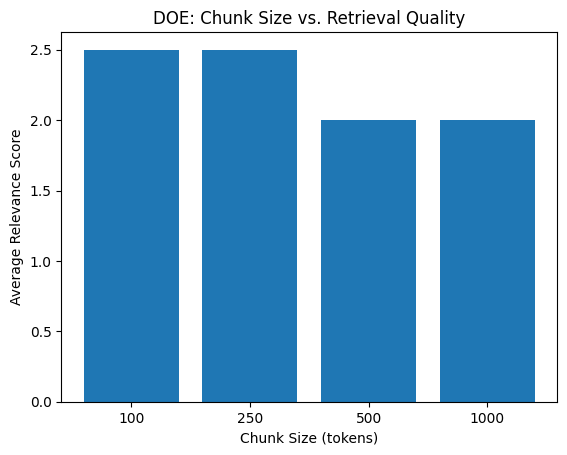

In [17]:
import matplotlib.pyplot as plt

plt.bar(summary.chunk_size.astype(str), summary.score)
plt.xlabel("Chunk Size (tokens)")
plt.ylabel("Average Relevance Score")
plt.title("DOE: Chunk Size vs. Retrieval Quality")
plt.show()
